# Benchmark Performance For Log Loss = Binary Cross Entropy

**Table of Contents** <a name="toc"></a>
- [1. Numpy vs different Cython implementations](#chapter_1)
  - [1.1 Implementation](#chapter_1_1)
  - [1.2. Simple Timings](#chapter_1_2)
  - [1.3 Benchmark Loss](#chapter_1_3)
  - [1.4 Benchmark Gradient](#chapter_1_4)
- [2. Numpy vs Loop Wrap - Numerical Stable Implementation](#chapter_2)
  - [2.1 Implementaion](#chapter_2_1)
  - [2.2 Benchmark Loss](#chapter_2_2)

In [1]:
%load_ext cython

In [2]:
from collections import OrderedDict
import numpy as np
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurtu import delayed, timeit, Benchmark


# See https://github.com/mwaskom/seaborn/issues/1986
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height =5)
#g.map(plt.errorbar, "N", "mean", yerr=df.wall_time.reset_index()['std']);

# This works
# See https://stackoverflow.com/a/30428808
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

## 1. Numpy vs different Cython implementations <a name="chapter_1"></a>

### 1.1 Implementation <a name="chapter_1_1"></a>
With $\eta = \mathrm{raw\_prediction}$ and $\mathrm{y_{pred}} = expit(\eta) = \frac{exp(\eta)}{1 + exp(\eta)}$ we have
$$log\_loss =  log(1 + exp(\eta)) - y_{true} \eta$$

In [3]:
# numpy ufunc version
# Note: log1p(exp(x)) is faster than logaddexp(x)
def np_logloss(y_true, raw):
    # logaddexp(0, x) = log(1 + exp(x))
    # return np.logaddexp(0, raw) - y_true * raw
    #
    # numerically stable, but slower
    # pos = raw > 0
    # out = - y_true * raw
    # out[pos] += raw[pos] + np.log1p(np.exp(-raw[pos]))
    # out[~pos] += np.log1p(np.exp(raw[~pos]))
    # return out
    #
    # return np.where(raw >= 0, raw + np.log1p(np.exp(-raw)) - y_true * raw, np.log1p(np.exp(raw)) - y_true * raw)
    #
    # fast, but unstable for raw > 700
    return np.log1p(np.exp(raw)) - y_true * raw
    

def np_gradient(y_true, raw):
    return expit(raw) - y_true

In [4]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef void generic_loop(fpointer f, double[::1] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])

### 1. C level functions
cdef double c_logloss(double y_true, double raw) nogil:
    if raw <= 0:
        return log1p(exp(raw)) - y_true * raw
    else:
        # log(1 + exp(x)) = x + log(1 + exp(-x))
        return raw + log1p(exp(-raw)) - y_true * raw

    
cdef inline double c_gradient(double y_true, double raw) nogil:
        return expit(raw) - y_true


### 2. ndarray via loop over C level functions
def p_logloss(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


def p_gradient(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


### 3. ndarray via generic loop, i.e. function pointer to C level functions
def p_logloss_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_logloss, y_true, raw, out)        
    return out


def p_gradient_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_gradient, y_true, raw, out)        
    return out


### 4. Class implementation, similar to 1. and 2.
cdef class Logloss():
    
    @staticmethod
    cdef double static_logloss(double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
    
    @staticmethod
    cdef double static_gradient(double y_true, double raw) nogil:
            return expit(raw) - y_true

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_logloss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_gradient(y_true[i], raw[i])
            
        return np.asarray(out)

    def loss_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_logloss, y_true, raw, out)
        return out
    
    def gradient_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_gradient, y_true, raw, out)
        return out


### 5. Class using virtual inheritance, i.e. loop in base class
# is inherited to derived class
cdef class BaseLoss():

    cdef double _loss(self, double y_true, double raw) nogil:
        return 1.
    
    cdef double _gradient(self, double y_true, double raw) nogil:
        return 1.

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._loss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._gradient(y_true[i], raw[i])
            
        return np.asarray(out)


cdef class Logloss_virtual(BaseLoss):

    cdef double _loss(self, double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
        
    cdef double _gradient(self, double y_true, double raw) nogil:
        return expit(raw) - y_true

### 1.2. Simple Timings <a name="chapter_1_2"></a>
[back to TOC](#toc)

In [4]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [5]:
[np.sum(np_logloss(y_true, raw) - p_logloss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - p_logloss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_virtual().loss(y_true, raw))
]

[1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14]

In [6]:
%%timeit -r10 -n100
np_logloss(y_true, raw)

1.36 ms ± 103 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [7]:
%%timeit -r10 -n100
p_logloss(y_true, raw)

2.56 ms ± 131 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [8]:
%%timeit -r10 -n100
p_logloss_generic(y_true, raw)

2.52 ms ± 106 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
%%timeit -r10 -n100
Logloss().loss(y_true, raw)

2.51 ms ± 104 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
%%timeit -r10 -n100
Logloss().loss_generic(y_true, raw)

2.66 ms ± 125 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [11]:
%%timeit -r10 -n100
Logloss_virtual().loss(y_true, raw)

2.61 ms ± 93 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
[np.sum(np_gradient(y_true, raw) - p_gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - p_gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient(y_true, raw)),
  np.sum(np_gradient(y_true, raw) - Logloss().gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_virtual().gradient(y_true, raw))
]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [13]:
%%timeit -r10 -n500
np_gradient(y_true, raw)

647 µs ± 19.8 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [14]:
%%timeit -r10 -n500
p_gradient(y_true, raw)

722 µs ± 31.8 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [15]:
%%timeit -r10 -n500
p_gradient_generic(y_true, raw)

730 µs ± 19.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [16]:
%%timeit -r10 -n500
Logloss().gradient(y_true, raw)

718 µs ± 17.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [17]:
%%timeit -r10 -n500
Logloss().gradient_generic(y_true, raw)

854 µs ± 27 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [18]:
%%timeit -r10 -n500
Logloss_virtual().gradient(y_true, raw)

868 µs ± 22.9 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


### 1.3 Benchmark Loss <a name="chapter_1_3"></a>
[back to TOC](#toc)

In [20]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_logloss, "np_logloss"),
             (p_logloss, "p_logloss"),
             (p_logloss_generic, "p_logloss_generic"),
             (Logloss().loss, "Logloss().loss"),
             (Logloss().loss_generic, "Logloss().loss_generic"),
             (Logloss_virtual().loss, "Logloss_virtual().loss")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [21]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss = bench(benchmark_cases())

CPU times: user 11min 2s, sys: 43.6 s, total: 11min 46s
Wall time: 12min 13s


In [36]:
df = df_loss
df.head()

wall_time                         peak_memory       \
                               mean       max           std        mean  max   
N  function                                                                    
10 Logloss().loss          0.000007  0.000011  1.114722e-06         0.0  0.0   
   Logloss().loss_generic  0.000006  0.000012  1.409815e-06         0.0  0.0   
   Logloss_virtual().loss  0.000007  0.000016  2.438263e-06         0.0  0.0   
   np_logloss              0.000003  0.000006  5.750105e-07         0.0  0.0   
   p_logloss               0.000005  0.000006  2.097798e-07         0.0  0.0   

                                
                           std  
N  function                     
10 Logloss().loss          0.0  
   Logloss().loss_generic  0.0  
   Logloss_virtual().loss  0.0  
   np_logloss              0.0  
   p_logloss               0.0

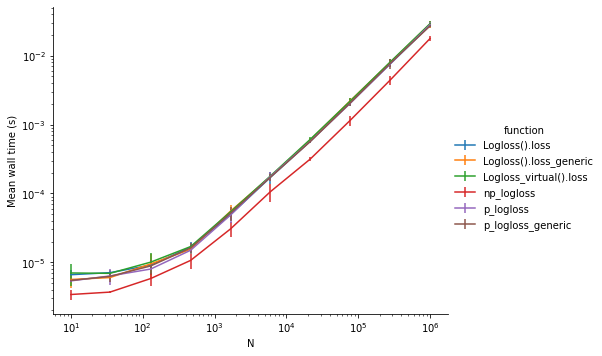

In [23]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

Error propagation: $\sigma^2(x/y) \approx \left(\frac{\partial}{\partial x}\frac{x}{y}\right)^2 \sigma_x^2 + \left(\frac{\partial}{\partial y}\frac{x}{y}\right)^2 \sigma_y^2
= \frac{1}{y^2} \sigma_x^2 + \frac{x^2}{y^4} \sigma_y^2 $

In [37]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().loss,1.938074,0.462121
1,10,Logloss().loss_generic,1.652131,0.498412
2,10,Logloss_virtual().loss,2.053569,0.794268
3,10,np_logloss,1.000000,0.238410
4,10,p_logloss,1.577483,0.272954


In [38]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().loss', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().loss_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().loss', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_logloss', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_logloss_generic', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

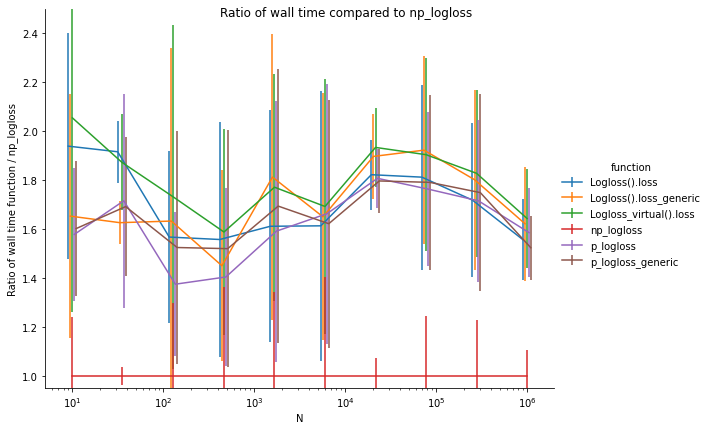

In [41]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss")

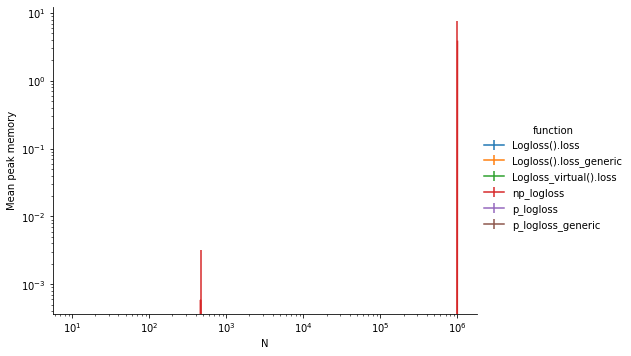

In [27]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

### 1.4 Benchmark Gradient <a name="chapter_1_4"></a>
[back to TOC](#toc)

In [28]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_gradient, "np_gradient"),
             (p_gradient, "p_gradient"),
             (p_gradient_generic, "p_gradient_generic"),
             (Logloss().gradient, "Logloss().gradient"),
             (Logloss().gradient_generic, "Logloss().gradient_generic"),
             (Logloss_virtual().gradient, "Logloss_virtual().gradient")
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [29]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_gradient = bench(benchmark_cases())

CPU times: user 10min 4s, sys: 54.1 s, total: 10min 58s
Wall time: 11min 44s


In [42]:
df = df_gradient

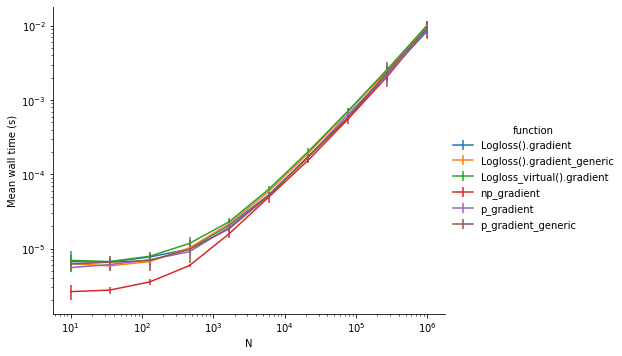

In [31]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

In [43]:
df_reference = df.wall_time.reset_index().query("function == 'np_gradient'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().gradient,2.532110,0.844441
1,10,Logloss().gradient_generic,2.387265,0.636881
2,10,Logloss_virtual().gradient,2.640838,1.028901
3,10,np_gradient,1.000000,0.324735
4,10,p_gradient,2.109500,0.493899


In [44]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().gradient', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().gradient_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().gradient', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_gradient', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_gradient_generic', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

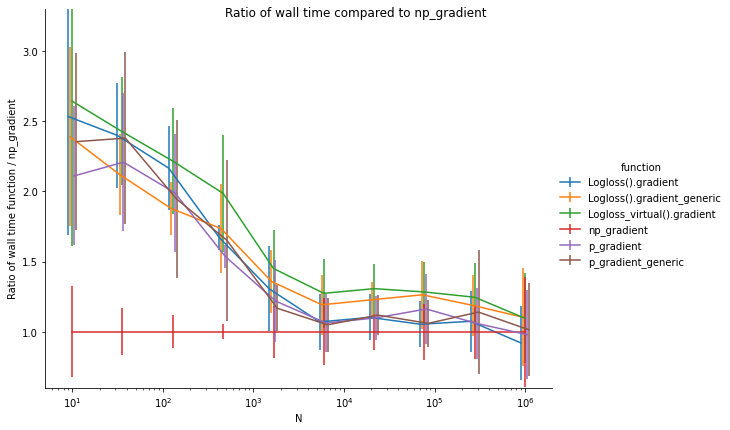

In [50]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log")
g.set(ylim=(0.6, 3.3))
g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_gradient")

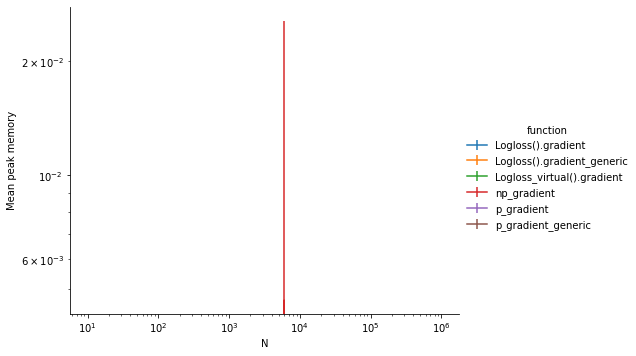

In [35]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

## 2. Numpy vs Loop Wrap - Numerical Stable Implementation <a name="chapter_2"></a>
[back to TOC](#toc)

See http://fa.bianp.net/blog/2019/evaluate_logistic/ and https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf as references on who to implement log loss in a numerically stable way.

### 2.1 Implementaion <a name="chapter_2_1"></a>
[back to TOC](#toc)

In [5]:
# 1. numpy ufunc version, this time the stable version
# Numerically stable log(1 + exp(x))
def np_log1pexp(x):
    return np.piecewise(x,
                        [x <= -37, (-37 < x) & (x <= 18), (18 < x) & (x <= 33.3), x > 33.3],
                        [lambda x: np.exp(x),
                         lambda x: np.log1p(np.exp(x)),
                         lambda x: x + np.exp(-x),
                         lambda x: x])
def np_logloss_stable(y_true, raw):
    # np.log1p(np.exp(raw)) - y_true * raw
    return np_log1pexp(raw) - y_true * raw

In [6]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

# Compiler flags to detect non-vetorized loops:
# Sebastien Ponce "Practical Vectorization" CERN 2019
# https://indico.cern.ch/event/771113/contributions/3203712/attachments/1746730/3022094/PracticalVectorization.pres.pdf
# icc: -vec-report=5
# clang: -Rpass-missed=loop-vectorize -Rpass-analysis=loop-vectorize
# gcc: -fopt-info-vec-missed

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef void generic_loop(fpointer f, double[:] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])
            
            
cdef double generic_sum(fpointer f, double[:] y_true, double[::1] raw):
    cdef:
        int i
        int size = y_true.shape[0]
        double out = 0.
    with nogil:
        for i in range(size):
            out += f(y_true[i], raw[i])
        return out


# Numerically stable log(1 + exp(x))
cdef inline double log1pexp(double x) nogil:
    if x <= -37:
        return exp(x)
    elif x <= 18:
        return log1p(exp(x))
    elif x <= 33.3:
        return x + exp(-x)
    else:
        return x


cdef double c_logloss(double y_true, double raw) nogil:
        return log1pexp(raw) - y_true * raw


### 2. ndarray via loop over C level functions
def p_logloss_stable(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


### 3. Class implementation via generic loop wrapper
# Note: No F- or C-contiguity expected for y_true
#       In real life, y_true might be a train split.
cdef class Logloss_stable():

    def loss_generic(self, double[:] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(c_logloss, y_true, raw, out)
        return out
    
    def loss_generic_sum(self, double[:] y_true, double[::1] raw):
        return generic_sum(c_logloss, y_true, raw)

In [7]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = 20 * rng.standard_normal(100_000, dtype=np.float64)  # make sure some values are <= -37 and > 33

In [8]:
raw.min(), raw.max()

(-91.87980390791544, 85.34683410460212)

In [9]:
# Same result on simple input
np_logloss(0.2, 0.5) - np_logloss_stable(0.2, 0.5)

0.0

In [10]:
np.sum(np.abs(np_logloss(y_true, raw) - np_logloss_stable(y_true, raw)))

5.826450433232822e-13

In [11]:
%%timeit -r20 -n50
np_logloss(y_true, raw)

1.45 ms ± 103 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [12]:
%%timeit -r20 -n50
np_logloss_stable(y_true, raw)

3.08 ms ± 198 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [14]:
%%timeit -r20 -n50
p_logloss_stable(y_true, raw)

2.07 ms ± 113 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [15]:
%%timeit -r20 -n50
Logloss_stable().loss_generic(y_true, raw)

2.16 ms ± 126 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


**Note: This time the generic loop is faster than numpy implementation.**<br>
Note also that this time `y_true` is not required to be C-contiguous in `Logloss_stable().loss_generic`, while is still is C-contiguous in `p_logloss_stable`.

In [16]:
np.sum(np_logloss_stable(y_true, raw)), Logloss_stable().loss_generic_sum(y_true, raw)

(800208.506890483, 800208.5068904647)

In [17]:
%%timeit -r20 -n50
np.sum(np_logloss_stable(y_true, raw))

3.12 ms ± 257 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [18]:
%%timeit -r20 -n50
Logloss_stable().loss_generic_sum(y_true, raw)

2.1 ms ± 51.6 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


**Note: numpy.sum() is so fast, there is no need to implement a separate "loop sum wrapper".**

### 2.2 Benchmark Loss <a name="chapter_2_2"></a>
[back to TOC](#toc)

In [19]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.binomial(1, 0.5, size=n_samples).astype(np.float64)
raw = 20 * rng.standard_normal(n_samples, dtype=np.float64)

func_list = [(np_logloss_stable, "np_logloss_stable"),
             (p_logloss_stable, "p_logloss_stable"),
             (Logloss_stable().loss_generic, "Logloss_stable().loss_generic"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [20]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss_stable = bench(benchmark_cases())

CPU times: user 4min 49s, sys: 22.3 s, total: 5min 12s
Wall time: 5min 24s


In [26]:
df = df_loss_stable
df.head()

wall_time                          \
                                      mean       max           std   
N  function                                                          
10 Logloss_stable().loss_generic  0.000006  0.000006  7.297432e-08   
   np_logloss_stable              0.000034  0.000053  4.689760e-06   
   p_logloss_stable               0.000006  0.000009  8.556466e-07   
35 Logloss_stable().loss_generic  0.000006  0.000007  2.120065e-07   
   np_logloss_stable              0.000031  0.000036  1.469544e-06   

                                 peak_memory            
                                        mean  max  std  
N  function                                             
10 Logloss_stable().loss_generic         0.0  0.0  0.0  
   np_logloss_stable                     0.0  0.0  0.0  
   p_logloss_stable                      0.0  0.0  0.0  
35 Logloss_stable().loss_generic         0.0  0.0  0.0  
   np_logloss_stable                     0.0  0.0  0.0

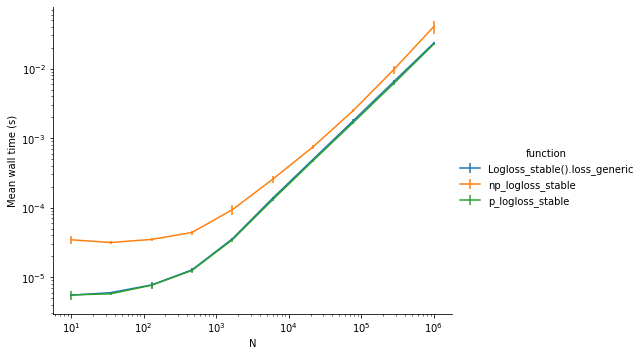

In [27]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

In [28]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss_stable'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss_stable().loss_generic,0.159584,0.021811
1,10,np_logloss_stable,1.000000,0.192378
2,10,p_logloss_stable,0.160623,0.033067
3,35,Logloss_stable().loss_generic,0.189707,0.011127
4,35,np_logloss_stable,1.000000,0.066023


In [29]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='p_logloss_stable', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_stable().loss_generic', 'N'] *= 1.05

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss_stable')

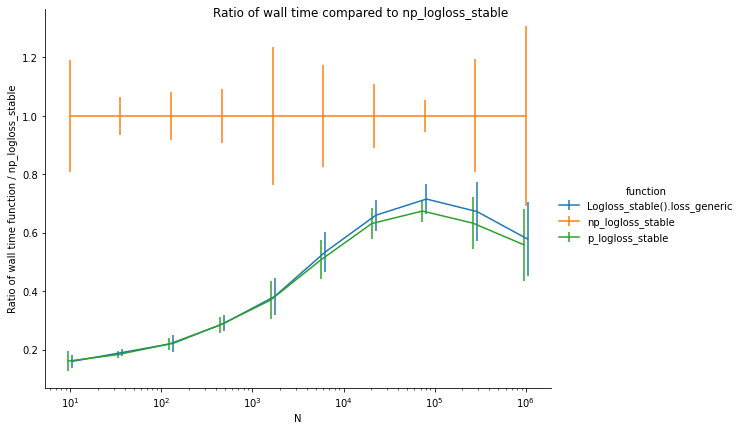

In [30]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
#g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss_stable")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss_stable")

**Note: The small performance difference between `p_logloss_stable` and `Logloss_stable().loss_generic` stems from the fact that `p_logloss_stable` requires and assumes C-contiguous `y_true`.**

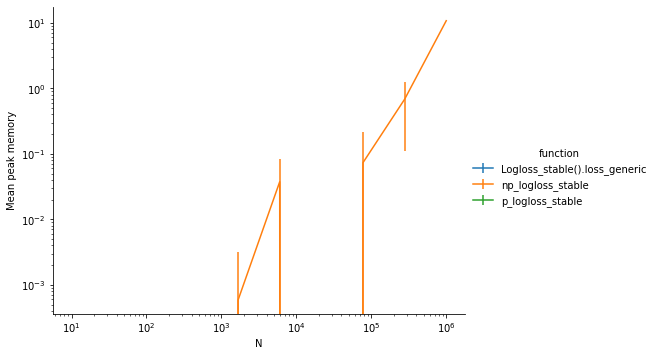

In [25]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()